## Reconhecimento de dígitos na base de dados MNIST

Neste notebook é descrito uma solução para o desafio de reconhecer dígitos (0 à 9) na base de dados [MNIST](http://yann.lecun.com/exdb/mnist/)

A base de dados MNIST consiste de 60 mil amostras no conjunto de treino e 10 mil no conjunto de teste, tamanho 28\*28 pixels.
Neste exercício, o conjunto de treino foi subdividido randomicamente entre treino e validação (80\% e 20\%, respectivamente), possibilitando aferir a acurácia do modelo a cada época de treino. 
É então selecionado o modelo que obteve maior acurácia no subconjunto de validação como sendo o modelo final, empregando-o no conjnunto de teste da base MNIST.

Foram usadas as seguintes bibliotecas:
numpy, pytorch, torchvision, matplotlib

In [6]:
from torch import nn,optim, utils
import torch
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np



As imagens dos conjuntos de treino e teste são baixadas e armazenadas localmente no caminho indicado, posteriormente convertidas em Tensores:

In [30]:
batch_size = 20
valid_size = 0.2

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='.pytorch/MNIST_data/', train=True,
                                           download=True, transform=transform)
test_data = datasets.MNIST(root='.pytorch/MNIST_data/', train=False,
                                          download=True, transform=transform)

O conjunto de treino é randomizado e dividido em dois subconjuntos: treino e validação, conforme a proporção estipulada anteriormente em $valid\_size$ (20%).

In [26]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
print("Quantidade de dados no subconjuntos de: \ntreino: %d \nvalidação: %d"%(len(train_idx),len(valid_idx)))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = utils.data.DataLoader(train_data, batch_size=batch_size,
            sampler=train_sampler)
valid_loader = utils.data.DataLoader(train_data, batch_size=batch_size, 
            sampler=valid_sampler)
test_loader = utils.data.DataLoader(test_data, batch_size=batch_size)


Quantidade de dados no subconjuntos de: 
treino: 48000 
validação: 12000


Adicionalmente, pode-se vizualizar o conjunto de treinamento (ou validação) atual e seus respectivos labels. No código abaixo é selecionado um batch de treino, as imagens são então convertidas para o formato numpy e plotadas com auxílio da biblioteca matplotlib.

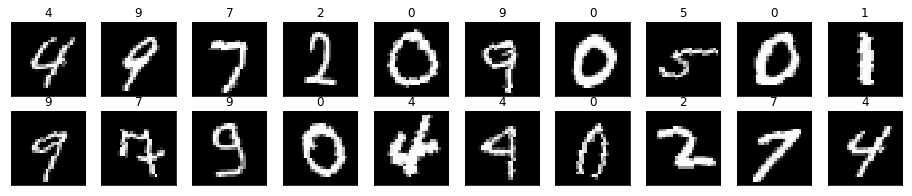

In [21]:
#Seleciona um batch de treino
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

#cria uma figura de tamanho 16x3 polegadas
fig = plt.figure(figsize=(16, 3))
#itera sob o batch selecionado, adicionando as imagens e labels na figura
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

## Definindo a Rede
Foi utilizado neste exercício uma rede perceptron com duas hidden layers, possuindo como entrada um Tensor de dimensão
784\*1 (que corresponde ao tamanho da imagem 28\*28 pixels), 1024 nós em cada hidden layer e um Tensor de dimensão 10, correspondendo à probabilidade de cada uma das 10 classes existentes no conjunto de dados. 
Foram empregados os seguintes hiperparâmetros:
- Função de ativação ReLU, 
- dropout 0.2
- função de loss [cross entropy](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) 
- otimização com [SGD (stochastic gradient descent)](http://ruder.io/optimizing-gradient-descent/index.html#stochasticgradientdescent) 
- learning rate em 0.01.
- treinamento com total de 40 épocas, sendo o modelo final aquele com maior acurácia na validação


In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        #converte a imagem de entrada p/ 784*1
        x = x.view(-1, 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)
epochs = 40
valid_loss_min = np.Inf

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


## Treinamento da Rede

In [24]:

for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    #itera os batchs de treino
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward() 
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    #validacao do modelo a cada época
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    print('Epoch {} \tTraining Loss: {:.6f} \tValid Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

    #Se erro da validação diminuir, salva o modelo atual no arquivo
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pth')
        valid_loss_min = valid_loss
        
        

Epoch 1 	Training Loss: 0.784863 	Valid Loss: 0.090616
Validation loss decreased (inf --> 0.090616).  Saving model ...
Epoch 2 	Training Loss: 0.343429 	Valid Loss: 0.071136
Validation loss decreased (0.090616 --> 0.071136).  Saving model ...
Epoch 3 	Training Loss: 0.275116 	Valid Loss: 0.057296
Validation loss decreased (0.071136 --> 0.057296).  Saving model ...
Epoch 4 	Training Loss: 0.223671 	Valid Loss: 0.048773
Validation loss decreased (0.057296 --> 0.048773).  Saving model ...
Epoch 5 	Training Loss: 0.193624 	Valid Loss: 0.042620
Validation loss decreased (0.048773 --> 0.042620).  Saving model ...
Epoch 6 	Training Loss: 0.168919 	Valid Loss: 0.036976
Validation loss decreased (0.042620 --> 0.036976).  Saving model ...
Epoch 7 	Training Loss: 0.149736 	Valid Loss: 0.034056
Validation loss decreased (0.036976 --> 0.034056).  Saving model ...
Epoch 8 	Training Loss: 0.135761 	Valid Loss: 0.029683
Validation loss decreased (0.034056 --> 0.029683).  Saving model ...
Epoch 9 	Trai

## Teste 
Por fim, o modelo obtido é utilizado para predição de classes no conjunto de testes da base MNIST.
É reportado também a acurácia para cada uma das 10 classes presentes neste conjunto, possibilitando identificar 
a proporção de acerto individualmente.

In [29]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.043575

Test Accuracy of     0: 98% (969/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1018/1032)
Test Accuracy of     3: 98% (996/1010)
Test Accuracy of     4: 98% (967/982)
Test Accuracy of     5: 97% (873/892)
Test Accuracy of     6: 98% (946/958)
Test Accuracy of     7: 98% (1010/1028)
Test Accuracy of     8: 98% (958/974)
Test Accuracy of     9: 97% (986/1009)

Test Accuracy (Overall): 98% (9850/10000)


Opcionalmente, pode-se visualizar um batch de imagens de testes e as predições obtidas pelo modelo, conforme a seguir:

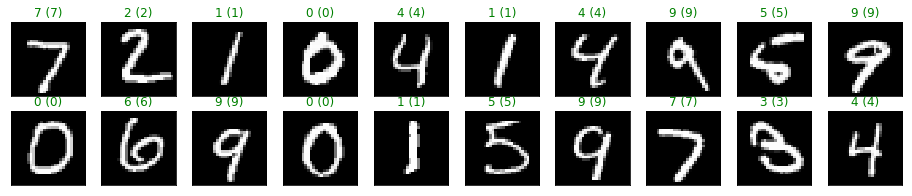

In [27]:

#Seleciona um batch de teste
dataiter = iter(test_loader)
images, labels = dataiter.next()

# testa imagens no modelo treinado
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

#cria uma figura de tamanho 16x3 polegadas
fig = plt.figure(figsize=(16, 3))
#itera sob o batch selecionado adicionando as imagens, predições e respectivos labels na figura
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))